* In this notebook, we will explore the effect of feature number on the R2, RMSE and MAE errors

In [405]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit.Chem as Chem

In [406]:
# ERed_data=pd.read_csv(r"../Data/Reduction_potential_213BzNSN.csv")
ERed_data=pd.read_csv(r"../Data/All_bzNSN_derivates_from_AL_and_DFT.csv",usecols=["SMILES","Ered(V)"])
ERed_data.head()

,SMILES,Ered(V)
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,1.27
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,1.27
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.24
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.22
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.20


# Check for duplicate SMILES

In [407]:
# There might be one or more valid SMILES that can represent one compound
def canonical_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    smiles = Chem.MolToSmiles(mol)
    return smiles

In [408]:
ERed_data["SMILES"]=ERed_data["SMILES"].apply(lambda x:canonical_smiles(x))

In [409]:
# Create a list for duplicate smiles
duplicates_smiles = ERed_data[ERed_data['SMILES'].duplicated()]['SMILES'].values
print(len(duplicates_smiles))

125


# Drop duplicate SMILESs

In [410]:
print(f"Before: ERed_data.shape={ERed_data.shape}")
ERed_data = ERed_data.drop_duplicates(subset=['SMILES'])
print(f"After: ERed_data.shape={ERed_data.shape}")
ERed_data.index=np.arange(len(ERed_data))

Before: ERed_data.shape=(2888, 2)
After: ERed_data.shape=(2763, 2)


* Feature Generation and Exploration

# RDKit Features

In [411]:
def RDkit_descriptors(smiles):
    """
    Function will return all 208 RDKit descriptors
    smiles is a pandas series or a list of smiles
    """
    from rdkit.ML.Descriptors import MoleculeDescriptors

    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 208 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

In [412]:
# Function call
Mol_descriptors,desc_names = RDkit_descriptors(ERed_data['SMILES'])

In [413]:
df_2Ddescp=pd.DataFrame(Mol_descriptors,columns=desc_names)
df_2Ddescp

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.673164,-4.313692,8.673164,0.278641,0.861773,291.424,270.256,291.151767,108,0,0.109421,-0.371076,0.371076,0.109421,1.550000,2.500000,3.300000,1.460045e-15,-0.246537,-2.572833e-17,-2.722027,-1.166959e-16,-2.828997,4.401419e-16,-1.048429,2.676061,1319.710561,32.317473,30.644316,10.460813,17.869915,15.574823,5.805120,3.612095,4.140543,2.417668,2.946116,1.611669,2.125660,-1.40,1.083990e+08,3.329290,5.179478,2.226066,153.172494,14.699729,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,8.74708,0.0,0.000000,26.845965,57.717337,32.698270,28.785930,34.136361,0.0,13.64699,0.0,6.851892,56.714739,11.605870,0.0,0.000000,9.799819,11.374773,0.000000,11.728187,60.561909,0.000000,6.851892,34.349381,6.042419,0.000000,11.033401,0.0,35.50,97.580675,0.0,0.0,4.899910,11.728187,0.0,0.0,0.0,0.0,8.747080,28.785930,177.855130,0.330538,-1.645123,0.000000,-5.035603,0.000000,-1.044342,0.000000,-31.627267,0.000000,0.571429,20,0,5,0,1,1,1,1,2,6,0,6,7,0,0,0,3,1.81752,86.1890,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8.626172,-4.129610,8.626172,0.326009,0.864637,292.408,272.248,292.135782,108,0,0.109421,-0.382853,0.382853,0.109421,1.550000,2.500000,3.350000,4.819916e-15,-0.248509,-2.855418e-17,-2.715352,-3.770785e-17,-2.810480,5.445269e-16,-1.039085,2.689828,1309.444040,31.447229,29.605351,10.421848,17.460996,15.062251,5.792548,3.480809,4.009257,2.464343,2.992790,1.663987,2.177978,-1.40,7.818057e+07,3.495314,5.53535

# Mordred features

In [414]:
def All_Mordred_descriptors(data,ignore_3D=False):
    """
    Function will return all mordred features
    """
    from mordred import Calculator, descriptors
    from rdkit.Chem import AllChem
    calc = Calculator(descriptors, ignore_3D=ignore_3D)
    # mols = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in data]
    mols = []
    for smi in data:
        m=Chem.MolFromSmiles(smi)
        m=Chem.AddHs(m)
        AllChem.EmbedMolecule(m)
        AllChem.UFFOptimizeMolecule(m)
        mols.append(m)
    # pandas df
    df = calc.pandas(mols)
    return df

In [415]:
df_mordred=All_Mordred_descriptors(ERed_data["SMILES"])

100%|██████████| 2763/2763 [01:49<00:00, 25.31it/s]


# RDkit 3d features

In [416]:
# 3D Descriptors
import rdkit.Chem.Descriptors3D as Rdkit3d

desc_3d=[]
for m in dir(Rdkit3d):
    if "__" not in m:
        desc_3d.append(str(m))
print(desc_3d)
desc_3d.remove('rdMolDescriptors')
print(desc_3d)

['Asphericity', 'Eccentricity', 'InertialShapeFactor', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3', 'RadiusOfGyration', 'SpherocityIndex', 'rdMolDescriptors']
['Asphericity', 'Eccentricity', 'InertialShapeFactor', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3', 'RadiusOfGyration', 'SpherocityIndex']


In [417]:
from rdkit.Chem.Descriptors3D import *
from rdkit.Chem import AllChem
def rdkit_all_3D(smi):
    # print(smi)
    m=Chem.MolFromSmiles(smi)
    m=Chem.AddHs(m)
    AllChem.EmbedMolecule(m)
    AllChem.UFFOptimizeMolecule(m)
    asp=Asphericity(m)
    ecc=Eccentricity(m)
    isf=InertialShapeFactor(m)
    npr1=NPR1(m)
    npr2=NPR2(m)
    pmi1=PMI1(m)
    pmi2=PMI2(m)
    pmi3=PMI3(m)
    RadG=RadiusOfGyration(m)
    Si=SpherocityIndex(m)
    return [asp,ecc,isf,npr1,npr2,pmi1,pmi2,pmi3,RadG,Si]

In [418]:
#add 3D descriptors
new_3d=ERed_data["SMILES"].apply(lambda x:rdkit_all_3D(x))
df_3Ddesc=pd.DataFrame(new_3d.to_list(),columns=desc_3d)

# Check for NaN

In [419]:
df_mordred.info()

<class 'mordred._base.pandas_module.MordredDataFrame'>
RangeIndex: 2763 entries, 0 to 2762
Columns: 1826 entries, ABC to mZagreb2
dtypes: bool(2), float64(1161), int64(339), object(324)
memory usage: 38.5+ MB


# ??

# Check for missing data

In [420]:
columns_with_nan=df_mordred.columns[df_mordred.isna().any()]
len(columns_with_nan)

0

# No missing data

https://www.simplypsychology.org/kurtosis.html

https://www.statology.org/skewness-interpretation/

# Interpretation of Skewness and kurtosis

- Kurtosis = 0, means the distribution is equal to the normal distribution
- When the Kurtosis > 0, the distribution is said to be leptokurtic, which means that it has ***sharper peak*** and ***heavier tails*** compared to the normal distribution 

**Sharper peak means less data values near the center**

**Heavier tails means more data values spread out along the tails**
- When the Kurtosis < 0, the distribution is said to be platykurtic, which means that it has ***flatter peak*** and ***thinner tails*** compared to the normal distribution 

**Flatter peak means more data values near the center**

**Thiner tails means less data values spread out along the tails**


# Skewness

- Skewness is used to describe the symmetry of a distribution
- Distribution is **left skewed** if it has a "tail" on the **left side of the distribution** 
- Distribution is **right skewed** if it has a "tail" on the **right side of the distribution**
- No skewness means perfect normal distribution (symmetrical on both sides of the mean=median=mode)

- Skewness < 0 (Left skewed)
- Skewness > 0 (Right skewed)
- Skewness = 0 ( No skewness)

In [421]:
print(f"ERed_data Skewness is = {ERed_data['Ered(V)'].skew():0.2f}")
print(f"ERed_data Kurtosis: is = {ERed_data['Ered(V)'].kurt():0.2f}")

ERed_data Skewness is = 0.41
ERed_data Kurtosis: is = -0.72


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016552BAA1C8>]],
      dtype=object)

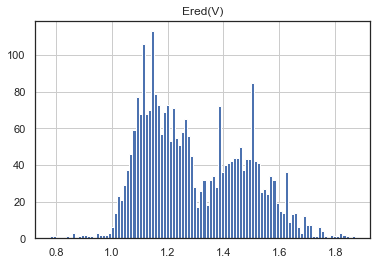

In [422]:
ERed_data.hist("Ered(V)",bins=100)

In [423]:
ERed_data["logEred"]=ERed_data["Ered(V)"].apply(lambda x:np.log(x))

In [424]:
print(f"log(ERed_data) Skewness is = {ERed_data['logEred'].skew():0.2f}")
print(f"log(ERed_data) Kurtosis: is = {ERed_data['logEred'].kurt():0.2f}")

log(ERed_data) Skewness is = 0.18
log(ERed_data) Kurtosis: is = -0.81


# With log transformation we were able to reduce the skewness

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001654B8D8C88>]],
      dtype=object)

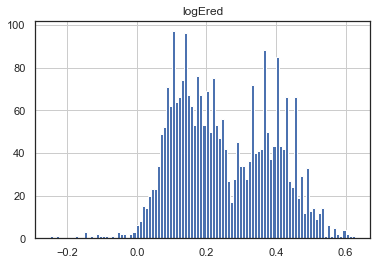

In [425]:
ERed_data.hist("logEred",bins=100)

In [519]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Text(0.5, 0, 'log(Ered(V))')

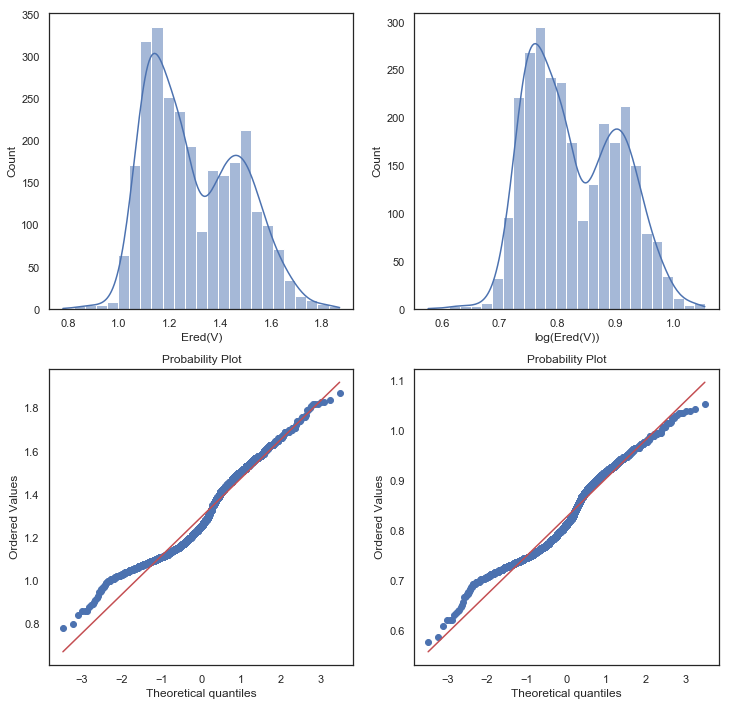

In [520]:
import matplotlib.pyplot as plt
import scipy.stats as stats
plot , ax = plt.subplots(2 , 2 , figsize = (12 , 12))
g = sns.histplot(ERed_data["Ered(V)"] , kde = True , ax = ax[0][0])
res = stats.probplot(ERed_data["Ered(V)"], plot=ax[1][0])
logEred = np.log1p(ERed_data["Ered(V)"])
g = sns.histplot(logEred , kde = True , ax = ax[0][1])
res = stats.probplot(logEred, plot= ax[1][1])
ax[0][1].set_xlabel("log(Ered(V))")

# Check skewness in all features

In [521]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

numeric_feats = df_mordred.dtypes[df_mordred.dtypes != "object"].index
# Xdata_btz._get_numeric_data()

# Check the skew of all numerical features
skewed_feats = df_mordred[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
n8ARing,52.535706
n9HRing,52.535706
n8Ring,52.535706
n9Ring,52.535706
n9ARing,52.535706
n8HRing,52.535706
n8AHRing,52.535706
n9AHRing,52.535706
SssssC,15.396761
Xc-6d,12.461025


In [522]:
skewness.tail(10)

,Skew
nG12FARing,-2.149927
FNSA3,-2.200023
PNSA3,-2.258155
ATSC8s,-2.299125
WNSA3,-2.340765
piPC10,-2.347732
piPC9,-2.379314
SdssC,-4.680479
GhoseFilter,-7.081935
Lipinski,-10.162614


In [523]:
df_mordred=df_mordred._get_numeric_data()

In [524]:
df_mordred_trans=df_mordred.copy()

In [526]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df_mordred_trans[feat] = boxcox1p(df_mordred_trans[feat], lam)

There are 1502 skewed numerical features to Box Cox transform


In [527]:
df_mordred_trans.shape,df_mordred.shape

((2763, 1502), (2763, 1502))

In [528]:
drop_object_feats = df_mordred.dtypes[df_mordred.dtypes == "object"].index
drop_object_feats

Index([], dtype='object')

In [529]:
transformed_feat=df_mordred_trans.dropna(axis=1).columns

In [530]:
not_transformed_feat=df_mordred_trans.columns[df_mordred_trans.isna().any()]

In [531]:
len(transformed_feat),len(not_transformed_feat)

(1331, 171)

In [532]:
# min-max scaller will transform not_transformed_feat to 0 and 1
df=df_mordred.loc[:,not_transformed_feat]

In [533]:
df_norm=(df-df.min())/(df.max()-df.min())

In [534]:
from scipy.special import boxcox1p
skewed_features = not_transformed_feat
lam = 0.15
for feat in skewed_features:
    df_norm[feat] = boxcox1p(df_norm[feat], lam)

In [535]:
df_mordred_trans_all=pd.concat([df_norm,df_mordred_trans[transformed_feat]],axis=1)

In [536]:
df_mordred_trans_all.columns[df_mordred_trans_all.isna().any()]

Index([], dtype='object')

In [537]:
# # Xdata_btz=pd.concat([df_mordred,df_molprop,df_2Ddescp,df_3Ddesc],axis=1)
# Xdata_btz=pd.concat([df_mordred_trans_all,df_3Ddesc],axis=1)
# print(Xdata_btz.shape)
# Xdata_btz.head()

Xdata_btz=df_mordred_trans_all

In [539]:
# Remove columns with all 0
print(f"Initial Xdata_btz shape = %d x %d" %Xdata_btz.shape)
Xdata_btz=Xdata_btz.drop(Xdata_btz.columns[Xdata_btz.eq(0).all()],axis=1)
print(f"Xdata_btz shape (now) = %d x %d" %Xdata_btz.shape)

Initial Xdata_btz shape = 2763 x 1502
Xdata_btz shape (now) = 2763 x 1256


In [540]:
# Remove duplicates
print(f"Initial Xdata_btz shape = %d x %d" %Xdata_btz.shape)
Xdata_btz=Xdata_btz.loc[:,~Xdata_btz.columns.duplicated()].copy()
print(f"Xdata_btz shape (now) = %d x %d" %Xdata_btz.shape)

Initial Xdata_btz shape = 2763 x 1256
Xdata_btz shape (now) = 2763 x 1256


In [541]:
all_desc=Xdata_btz.columns
print(len(all_desc))

1256


# add more ringstats

In [542]:
def ring_stats(smiles):
    """
    if smi="CN1CN(C)c2cc3nsnc3cc21" 
    then ring_stats(smi) will return a list of number of rings of size [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    # rings start with size 3
    Output:    [0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0]
    molecule has 2 and 1 rings of size 5 and 6, respectively
    """
    m = Chem.MolFromSmiles(smiles)
    
    d=13 # rings won't have more than 13 atoms
    nring=[0]*d
    rings=m.GetRingInfo()
    for ring in rings.AtomRings():
        sr=""
        n=0
        for atom in ring:
            sr+=m.GetAtomWithIdx(atom).GetSymbol()
            n+=1

        if(n<d):
            nring[n]+=1 # total rings
    return nring    

In [543]:
def hetroring_stats(smiles):
    """
    Retrun a list of number of hetrocylces of sizes from 3 to 13

    Eg. if smi="CN1CN(C)c2cc3nsnc3cc21" 
    # rings start with size 3
    then the hetroring_stats(smi) will return :  hetrocycle ring of size [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    Output: [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]
    There are 2 hetrorings of size 5
    """
    m = Chem.MolFromSmiles(smiles)
    
    d=13 # rings won't have more than 13 atoms
    nHring=[0]*d
    
    rings=m.GetRingInfo()
    for ring in rings.AtomRings():
        sr=""
        n=0
        for atom in ring:
            sr+=m.GetAtomWithIdx(atom).GetSymbol()
            n+=1

        if(n<d):
            c=sr.count('C')
            if(c<n): # hetro-atom cycle
                nHring[n]+=1
    return nHring    

In [544]:
def other_ring_stats(smiles):
    """
    Return a list which contains [number of carbon atoms (nC) in all homocycles, nC in all heterocycles,nN in all hetrocycle, nS in all hetrocycles, nO in all hetrocycles ]
    """
    m = Chem.MolFromSmiles(smiles)
    
    numH_C,numH_N,numH_S,numH_O=0,0,0,0
    num_C_homo=0
    ri=m.GetRingInfo()
    
    for r in ri.AtomRings():
        sr=""
        ringsize=0
        for i in r:
            sr+=m.GetAtomWithIdx(i).GetSymbol()
            ringsize+=1
        # print(sr)
        num_c=sr.count('C')
        
        # count number of S, N, C, and O in hetrocycles
        if  num_c < ringsize: # count in hetrocycles
            numH_C+=num_c
            numH_N+=sr.count('N')
            numH_S+=sr.count('S')
            numH_O+=sr.count('O')
        else:
            num_C_homo+=ringsize
    return [num_C_homo,numH_C,numH_N,numH_O,numH_S]

In [607]:
new_RingD=ERed_data["SMILES"].apply(lambda smi:other_ring_stats(smi)).to_list()
col_txt=["nhomo_C","nhetro_C","nhetro_N","nhetro_O","nhetro_S"]
df_ringD=pd.DataFrame(new_RingD,columns=col_txt)
df_ringD=df_ringD.drop(df_ringD.columns[df_ringD.eq(0).all()],axis=1)

In [546]:
# new_RingD=ERed_data["SMILES"].apply(lambda smi:ring_stats(smi)).to_list()
# col_txt=["nring"+str(i) for i in range(len(new_RingD[0]))]

# df_ring=pd.DataFrame(new_RingD,columns=col_txt)
# df_ring=df_ring.drop(df_ring.columns[df_ring.eq(0).all()],axis=1)

In [547]:
# new_RingD=ERed_data["SMILES"].apply(lambda smi:hetroring_stats(smi)).to_list()
# col_txt=["nHring"+str(i) for i in range(len(new_RingD[0]))]

# df_ringh=pd.DataFrame(new_RingD,columns=col_txt)
# df_ringh=df_ringh.drop(df_ringh.columns[df_ringh.eq(0).all()],axis=1)

In [608]:
def substruct_in_smi(mol_smi_str,pat_smi_str):
    """
    This function will return True if the substructure (pattern) is present in the SMILES string.
    Input: smi_str = A SMILES string;   sub_str = Pattern 
    Output: True (substruture found in the smi); False (substruture not found in the smi)
    """   
    mol = Chem.MolFromSmiles(mol_smi_str)
    pat = Chem.MolFromSmiles(pat_smi_str) 

    return mol.HasSubstructMatch(pat)

In [609]:
newclass=ERed_data["SMILES"].apply(lambda x:1*substruct_in_smi(mol_smi_str=x,pat_smi_str="c1c2c(cc3nsnc13)N(C)CN2C"))
df_class=pd.DataFrame(newclass.to_list(),columns=["Scaffold"])

In [610]:
Xdata_btz_corr_scaffold_rings=pd.concat([Xdata_btz,df_ringD,df_class],axis=1)
# # Xdata_btz_uncorr_clean_scaffold_rings

In [551]:
# Xdata_btz_corr_scaffold_rings.shape

In [552]:
# sub6="CN1CCN(c(c2)c1cc3c2nsn3)C"
# newclass=ERed_data["SMILES"].apply(lambda x:1*substruct_in_smi(mol_smi_str=x,pat_smi_str=sub6))
# df_class6=pd.DataFrame(newclass.to_list(),columns=["Scaffold"])

In [553]:
# import datamol as dm
# dm.to_image([Chem.MolFromSmiles(sub6), Chem.MolFromSmiles("c1c2c(cc3nsnc13)N(C)CN2C")])

# Drop columns with identical values

In [611]:
# Xdata_btz_clean=Xdata_btz.loc[:,Xdata_btz.nunique()>1]
Xdata_btz_clean=Xdata_btz_corr_scaffold_rings.loc[:,Xdata_btz_corr_scaffold_rings.nunique()>1]

In [612]:
Xdata_btz_clean.shape

(2763, 1245)

In [613]:
def remove_corr_features(Xdata,corr_cutoff = 0.75):
    """
    This function will drop highly correlated features
    Output: a pd.Dataframe 
    """
    cor_matrix=Xdata.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_cutoff)]
    print(f"Dropped %d features with correlation coeff. > %0.2f" %(len(to_drop),corr_cutoff))

    Xdata=Xdata.drop(columns=to_drop,axis=1)
    print(f"Remaining features %d" %(Xdata.shape[1]))
    return Xdata

In [662]:
Xdata_btz_uncorr=remove_corr_features(Xdata=Xdata_btz_clean, corr_cutoff=0.62)
print(Xdata_btz_uncorr.shape)

Dropped 1178 features with correlation coeff. > 0.62
Remaining features 67
(2763, 67)


# ERed and Feauture correlation

In [663]:
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [664]:
target = 'Ered(V)'
descriptors=Xdata_btz_uncorr.columns
corr_ered_feat=[]

In [665]:
X=Xdata_btz_uncorr
Y=ERed_data["Ered(V)"]
print(f"X.shape={X.shape},Y.shape={Y.shape}")

X.shape=(2763, 67),Y.shape=(2763,)


# Find outliers with IQR

In [666]:
#Xdata_btz_uncorr_clean
q1_btz=ERed_data["Ered(V)"].quantile(0.25)
q3_btz=ERed_data["Ered(V)"].quantile(0.75)
IQR_btz=q3_btz-q1_btz
low_lim,up_lim=q1_btz-1.5*IQR_btz,q3_btz+1.5*IQR_btz
print(f"btz Q1={q1_btz:0.2f}, Q3={q3_btz:0.2f}, IQR={IQR_btz:0.2f}, low_lim={low_lim:0.2f}, up_lim={up_lim:0.2f}")
df_btz_outlier_iqr = ERed_data[(ERed_data["Ered(V)"] < low_lim)|(ERed_data["Ered(V)"] > up_lim)]
print(f"df_btz_outlier_iqr.shape={df_btz_outlier_iqr.shape}")

btz Q1=1.14, Q3=1.45, IQR=0.31, low_lim=0.69, up_lim=1.91
df_btz_outlier_iqr.shape=(0, 3)


# No outliers found

# Check model performance

In [667]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


import torch, gpytorch
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE

# Machine learning-realated functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # For normalizing inputs
from sklearn.decomposition import PCA # Principle component analysis

In [668]:
def gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1,verbose=False):
    
    """
    Gaussian Process Regression implementation with the GPyTorch
    
    Input: gpregression_pytorch(X_train,y_train,num_iter,learning_rate)
    
    Retrun: trained_model, trained_likelihood

    """
    # nfeatures=X_train.shape[1]
    train_x=torch.from_numpy(np.array(X_train))
    train_y=torch.from_numpy(np.array(y_train))
    torch.set_default_dtype(torch.float64)

    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
 
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else num_iter


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer # for hyperparameter tuning
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose*1*((i+1)%50==0 or i==0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (i + 1, training_iter, loss.item(),model.covar_module.base_kernel.lengthscale.item(),model.likelihood.noise.item()))
            # print('Iter %d/%d - Loss: %.3f    noise: %.3f' % (i + 1, training_iter, loss.item(),model.likelihood.noise.item()))
        optimizer.step()

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    return model,likelihood

def gprediction_pytorch(model,likelihood,X_test):
    
    """
    Gaussian Process Predictions with gpr_pytorch
    
    Use: 
    model, likelihood = gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1)  
    ypred, ysigma = gprediction__pytorch(model,likelihood,X_test)

    Return: ypred and ysigma numpy arrays
    
    """
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.from_numpy(np.array(X_test))
        torch.set_default_dtype(torch.float64)
        observed_pred = likelihood(model(test_x))
        ypred = observed_pred.mean.numpy()
        ysigma = observed_pred.stddev.numpy()
    return ypred,ysigma

In [669]:
def do_pca(xtrain=None, xtest=None, rvar=None, npc=None):
    """
    Usage: do_pca(xtrain=xtrain, xtest=test) 
    Caution: Do test_train_split and scaling before pca
    Return: Transformed xtrain and xtest if they are not None
    """
    
    if xtrain is not None:
        
        pca = PCA().fit(xtrain)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if rvar is not None and npc is None:
            n_comp = 1+np.nonzero(evr > rvar)[0][0]
            print(str(n_comp)+" principal components can describe > "+ str(rvar*100)+ "% of variance in the data")
        elif rvar is None and npc is not None:
            n_comp = npc

        
        print("Selected "+str(n_comp)+" components for PCA")
        
        # col=[]
        # for i in range(1,1+n_comp,1):
        #     col.append("PC"+str(i))

        pca = PCA(n_components=n_comp)
        xtrain = pca.fit_transform(xtrain) 
        # xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=pca.transform(xtest)
            # xtest=pd.DataFrame(xtest,columns=col)
            print("returning pca transformed train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only transformed train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [670]:
from sklearn.preprocessing import StandardScaler, RobustScaler
def do_scaling(scaler=StandardScaler(), xtrain=None, xtest=None):
    """
    Usage: do_scaling(scaler=MinMaxScaler(), xtrain=xtrain, xtest=test) 
    xtrain and xtest are pd.Dataframes
    Caution: Do test_train_split before scaling
    Return: return scaled non-None xtrain and xtest
    """
    st = scaler

    if xtrain is not None:
        col=xtrain.columns.values.tolist()
        xtrain=st.fit_transform(xtrain)  
        xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=st.transform(xtest)
            xtest=pd.DataFrame(xtest,columns=col)
            print("returning scaled train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only scaled train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [671]:
def gpr_one_pytorch(X,y,train_pc=0.8):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc) 

    xtrain, xtest = do_scaling(scaler=RobustScaler(),xtrain=X_train, xtest=X_test)

    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [672]:
def plot_Ered_gpr(y_true_train,y_pred_train,y_true_test,y_pred_test,y_pred_err_train=None,y_pred_err_test=None,err_bar=False,showfig=True,savefig=False,filename="gpr_pred.png",data=True):
    """
    Return r2,rmse and mae score if data = True
    Show image if showfig=True
    Save image if savefig=True
    """
    
    mae_train = round(MAE(y_true_train,y_pred_train),2)
    r2_train = round(r2_score(y_true_train,y_pred_train),2)
    rmse_train = round(np.sqrt(MSE(y_true_train,y_pred_train)),2)

    mae_test = round(MAE(y_true_test,y_pred_test),2)
    r2_test = round(r2_score(y_true_test,y_pred_test),2)
    rmse_test = round(np.sqrt(MSE(y_true_test,y_pred_test)),2)

    print(f"(Train: R2 = %0.2f, RMSE = %0.2f, MAE = %0.2f)" %(r2_train,rmse_train,mae_train))    
    print(f"(Test:  R2 = %0.2f, RMSE = %0.2f, MAE = %0.2f)" %(r2_test,rmse_test,mae_test))    
    
    if showfig:
        plt.figure(figsize=(6, 6)) 
        # plt.scatter(y_true,y_pred,color=color,label=label)
        if err_bar*(y_pred_err_train is not None):
            plt.errorbar(y_true_train,y_pred_train,yerr=y_pred_err_train,color="red",fmt='o',label="Train")

        if err_bar*(y_pred_err_test is not None):
            plt.errorbar(y_true_test,y_pred_test,yerr=y_pred_err_test,color="blue",fmt='o',label="Test")

        plt.plot([y_true_train.min()-0.1,y_true_train.max()+0.1],[y_true_train.min()-0.1,y_true_train.max()+0.1],color='black')
        
        string="$R^2$ (train) ="+str(r2_train)
        # plt.text(0.75,1.7,string)
        string="RMSE (train) ="+str(rmse_train)
        # plt.text(0.75,1.65,string)
        
        string="$R^2$ (test) ="+str(r2_test)
        # plt.text(0.75,1.60,string)
        string="RMSE (test)="+str(rmse_test)
        # plt.text(0.75,1.55,string)
        plt.xlabel('DFT calculated values (V)')
        plt.ylabel('GPR Predicted values (V)')
        # plt.xlim([0.7,2])
        # plt.ylim([0.7,2])
        # plt.yticks(np.arange(0.7,2,0.2))

        # plt.xticks(np.arange(0.7,2,0.2))
        plt.legend(loc='lower right') #best
        plt.tight_layout()
        print("Train: min error =", round(y_pred_err_train.min(),2),"max_err", round(y_pred_err_train.max(),2))
        print("Test: min error =", round(y_pred_err_test.min(),2),"max_err", round(y_pred_err_test.max(),2))
        if savefig:
            plt.savefig(filename,dpi=300,bbox_inches='tight')
        plt.show()


    if data:
        return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

In [673]:
Xdata_btz_uncorr.isnull().values.any()

False

# PCA 

test data is not provided, returning only scaled train data
No. of PC           Cumulative variance                                                             
--------------------------------------------------
1                   0.099424                                                                        
2                   0.192366                                                                        
3                   0.264258                                                                        
4                   0.321059                                                                        
5                   0.370939                                                                        
6                   0.413952                                                                        
7                   0.452604                                                                        
8                   0.486416                                                     

C:\Users\jaina\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


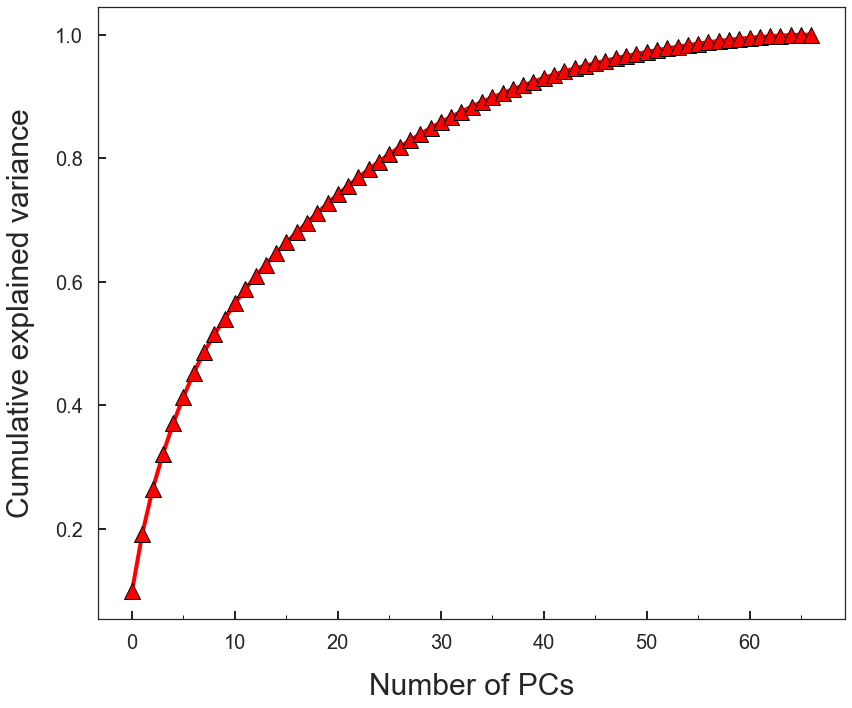

In [674]:
from sklearn.decomposition import PCA # Principle component analysis
import matplotlib.pyplot as plt  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

X=Xdata_btz_uncorr

X_st= do_scaling(scaler=StandardScaler(),xtrain=X, xtest=None)
pca = PCA().fit(X_st)

#Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
evr = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(evr, marker='^',markersize=16, markeredgecolor='black', 
         linestyle='-',linewidth=4, color='red')   # Plotting
plt.tight_layout()
# plt.savefig("./Figures/Xdata_reduced_pca.png",dpi=300)
print('{:<20s}{:<80s}'.format('No. of PC','Cumulative variance'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

# Features

In [675]:
from sklearn.model_selection import KFold

In [676]:
num_PCs = np.arange(20,Xdata_btz_uncorr.shape[1],10)
num_PCs

array([20, 30, 40, 50, 60])

In [677]:
def gpr_one_pca_pytorch(X,y,train_by_test=0.8,nPC=5,random_state=None):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_by_test,random_state=random_state) 

    xtrain, xtest = do_scaling(scaler=RobustScaler(),xtrain=X_train, xtest=X_test)
    # PCA
    n_PC = nPC  # Set number of principle components
    pca = PCA(n_components=n_PC)
        
    xtrain = pca.fit_transform(xtrain) 
    xtest=pca.transform(xtest)
    print(f"xtrain.shape={xtrain.shape},xtest.shape={xtest.shape}")
    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [678]:
def helper(X,y,nPC=5,random_state=None):
    y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_by_test=0.8,nPC=nPC,random_state=random_state)
    r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train=plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=False,savefig=False,data=True)
    return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

In [679]:
train_score = np.zeros([len(num_PCs),3])
test_score = np.zeros([len(num_PCs),3])

In [680]:
for idx,PCs in enumerate(num_PCs):
    print(f"--> %idx/num_PCs={100*idx/len(num_PCs)}  <--")
    # split train and test datasets
    X=Xdata_btz_uncorr
    # y=ERed_data["Ered(V)"]
    y=ERed_data["logEred"]
   
    test_score[idx][0],test_score[idx][1],test_score[idx][2],train_score[idx][0],train_score[idx][1],train_score[idx][2]=helper(X=X,y=y,nPC=PCs,random_state=8)

--> %idx/num_PCs=0.0  <--
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.93, RMSE = 0.04, MAE = 0.03)
(Test:  R2 = 0.81, RMSE = 0.06, MAE = 0.04)
--> %idx/num_PCs=20.0  <--
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
--> %idx/num_PCs=40.0  <--
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.06, MAE = 0.04)
--> %idx/num_PCs=60.0  <--
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.06, MAE = 0.04)
--> %idx/num_PCs=80.0  <--
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)
(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.85, RMSE = 0.05, MAE = 0.04)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


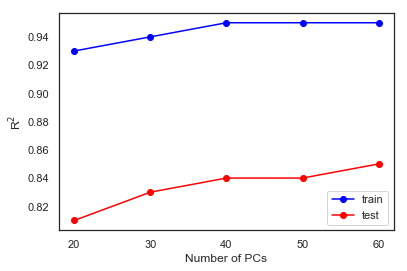

In [681]:
plt.plot(num_PCs,train_score[:,0],"-o",label="train",color="blue")
plt.plot(num_PCs,test_score[:,0],"-o",label="test",color="red")
plt.xlabel("Number of PCs")
plt.ylabel("R$^2$")
plt.legend()
plt.xticks(num_PCs)
plt.show()

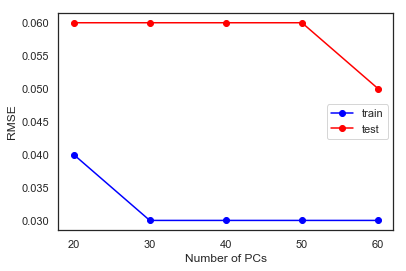

In [682]:
plt.plot(num_PCs,train_score[:,1],"-o",label="train",color="blue")
plt.plot(num_PCs,test_score[:,1],"-o",label="test",color="red")
plt.xlabel("Number of PCs")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(num_PCs)
plt.show()

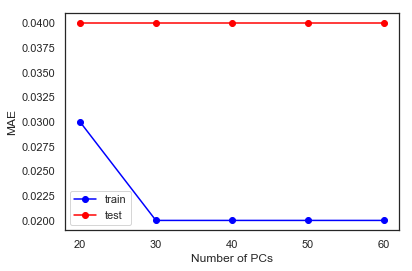

In [683]:
plt.plot(num_PCs,train_score[:,2],"-o",label="train",color="blue")
plt.plot(num_PCs,test_score[:,2],"-o",label="test",color="red")
plt.xlabel("Number of PCs")
plt.ylabel("MAE")
plt.legend()
plt.xticks(num_PCs)
plt.show()

# Overfitting with mordred features

returning scaled train and test data
xtrain.shape=(2210, 11),xtest.shape=(553, 11)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.92, RMSE = 0.04, MAE = 0.03)
(Test:  R2 = 0.78, RMSE = 0.07, MAE = 0.05)
Train: min error = 0.06 max_err 0.13
Test: min error = 0.06 max_err 0.13


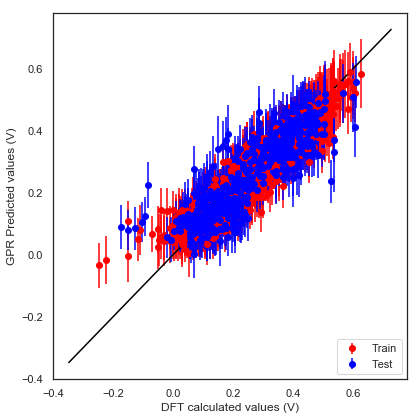

In [684]:
X=Xdata_btz_uncorr
y=ERed_data["logEred"]
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_by_test=0.8,nPC=11)

plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=False,data=False)

returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
Train: min error = 0.05 max_err 0.12
Test: min error = 0.05 max_err 0.1


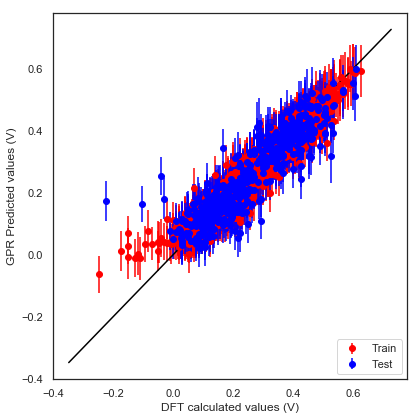

In [685]:
X=Xdata_btz_uncorr
y=ERed_data["logEred"]
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_by_test=0.8,nPC=30)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=False,data=False)

returning scaled train and test data
xtrain.shape=(2210, 51),xtest.shape=(553, 51)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
Train: min error = 0.05 max_err 0.11
Test: min error = 0.05 max_err 0.11


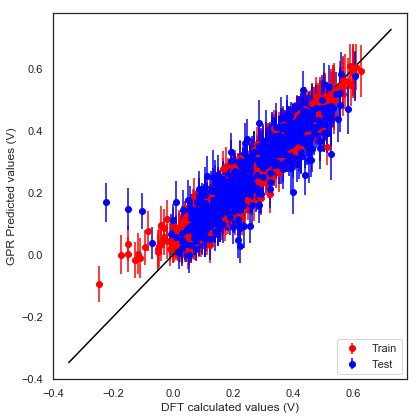

In [686]:
X=Xdata_btz_uncorr
y=ERed_data["logEred"]
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_by_test=0.8,nPC=51)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=False,data=False)

In [687]:
# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

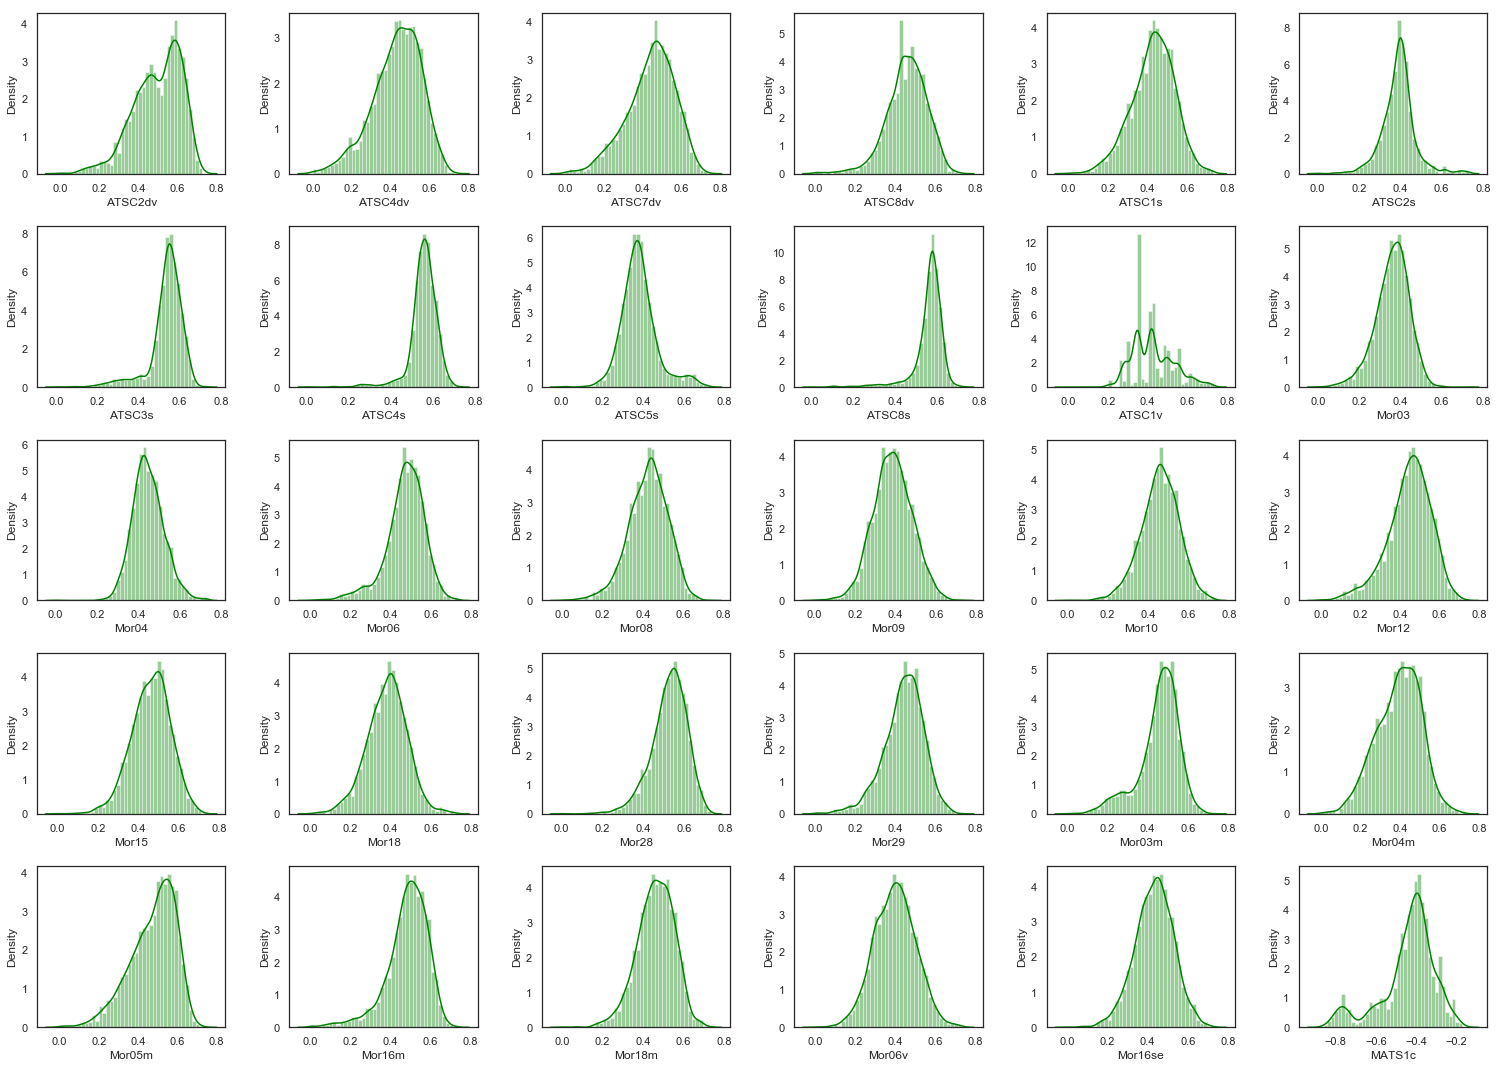

In [688]:
target = 'logEred'
descriptors=X.columns.to_list()
from scipy.stats import norm
nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):

            sns.distplot(x=X[descriptors[i]],color="green", ax = axs[r][c],bins=40,kde=True)

            axs[r][c].set_xlabel(descriptors[i])
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

In [689]:
Xdata_btz_uncorr.shape

(2763, 67)

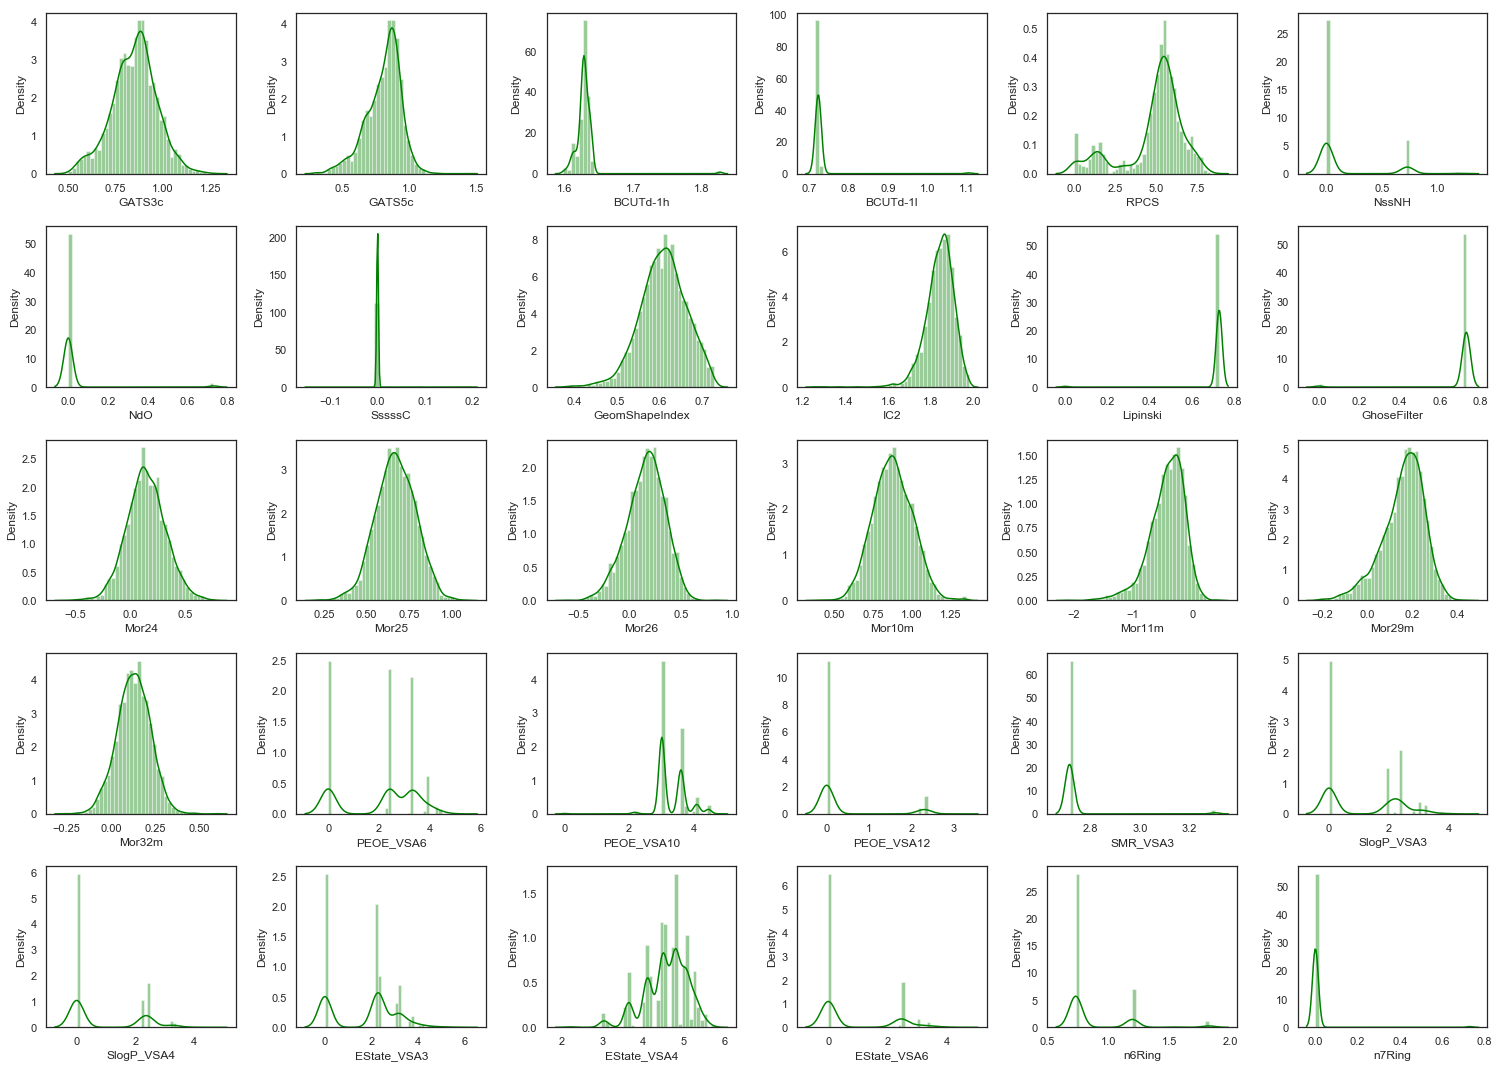

In [690]:
target = 'logEred'
descriptors=X.columns.to_list()
from scipy.stats import norm
nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+30
        
        if i < len(descriptors):

            sns.distplot(x=X[descriptors[i]],color="green", ax = axs[r][c],bins=40,kde=True)

            axs[r][c].set_xlabel(descriptors[i])
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

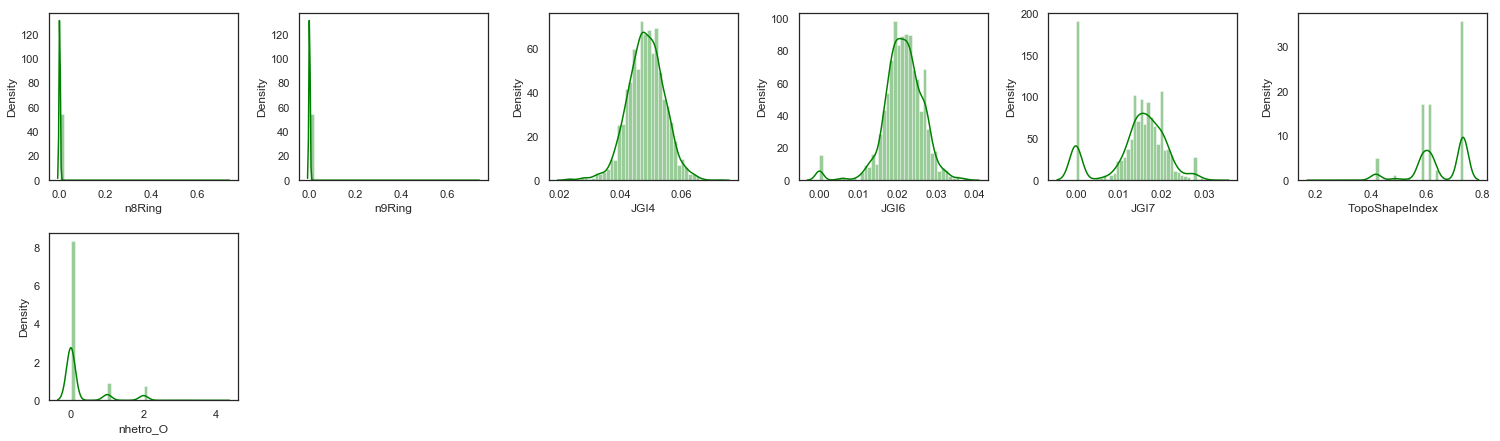

In [691]:
target = 'logEred'
descriptors=X.columns.to_list()
from scipy.stats import norm
nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+30+30
        
        if i < len(descriptors):

            sns.distplot(x=X[descriptors[i]],color="green", ax = axs[r][c],bins=40,kde=True)

            axs[r][c].set_xlabel(descriptors[i])
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

# Get Statistics

In [692]:
avg_train_score = np.zeros([len(num_PCs),3])
avg_test_score = np.zeros([len(num_PCs),3])

std_train_score = np.zeros([len(num_PCs),3])
std_test_score = np.zeros([len(num_PCs),3])

In [693]:
for idx,PCs in enumerate(num_PCs):
    print(f"--> %idx/num_PCs={100*idx/len(num_PCs)}  <--")
    # split train and test datasets
    X=Xdata_btz_uncorr
    y=ERed_data["logEred"]
    
    repeats=10
    r2_train,rmse_train,mae_train=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)
    r2_test,rmse_test,mae_test=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)

    for j in np.arange(repeats):
        print(f" ---> %repeat <-- ={100*j/repeats}")
        r2_test[j],rmse_test[j],mae_test[j],r2_train[j],rmse_train[j],mae_train[j]=helper(X=X,y=y,nPC=PCs)

    avg_test_score[idx] = r2_test.mean(),rmse_test.mean(),mae_test.mean()
    avg_train_score[idx] = r2_train.mean(),rmse_train.mean(),mae_train.mean()
    std_test_score[idx] = r2_test.std(),rmse_test.std(),mae_test.std()
    std_train_score[idx] = r2_train.std(),rmse_train.std(),mae_train.std()
    

--> %idx/num_PCs=0.0  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.04, MAE = 0.03)
(Test:  R2 = 0.82, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.81, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.93, RMSE = 0.04, MAE = 0.03)
(Test:  R2 = 0.80, RMSE = 0.06, MAE = 0.05)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.93, RMSE = 0.04, MAE = 0.03)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.05)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.04, MAE = 0.03)
(Test:  R2 = 0.82, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.81, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.80, RMSE = 0.06, MAE = 0.05)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.81, RMSE = 0.06, MAE = 0.05)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.93, RMSE = 0.04, MAE = 0.03)
(Test:  R2 = 0.81, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(2210, 20),xtest.shape=(553, 20)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.81, RMSE = 0.06, MAE = 0.04)
--> %idx/num_PCs=20.0  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.82, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.85, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.81, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.82, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.81, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(2210, 30),xtest.shape=(553, 30)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.85, RMSE = 0.05, MAE = 0.04)
--> %idx/num_PCs=40.0  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.82, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.86, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.82, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.85, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.86, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(2210, 40),xtest.shape=(553, 40)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.94, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.06, MAE = 0.04)
--> %idx/num_PCs=60.0  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.85, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(2210, 50),xtest.shape=(553, 50)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.85, RMSE = 0.05, MAE = 0.04)
--> %idx/num_PCs=80.0  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.85, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.85, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.84, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.95, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.88, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.86, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.87, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.86, RMSE = 0.05, MAE = 0.04)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.97, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.85, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.83, RMSE = 0.06, MAE = 0.04)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(2210, 60),xtest.shape=(553, 60)
(Train: R2 = 0.96, RMSE = 0.03, MAE = 0.02)
(Test:  R2 = 0.82, RMSE = 0.06, MAE = 0.04)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


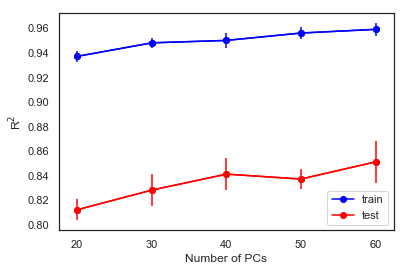

In [694]:
plt.plot(num_PCs,avg_train_score[:,0],"-o",label="train",color="blue")
plt.plot(num_PCs,avg_test_score[:,0],"-o",label="test",color="red")

plt.scatter(num_PCs,avg_train_score[:,0],color="blue")
plt.scatter(num_PCs,avg_test_score[:,0],color="red")

plt.errorbar(num_PCs,avg_train_score[:,0],yerr=std_train_score[:,0],color="blue")
plt.errorbar(num_PCs,avg_test_score[:,0],yerr=std_test_score[:,0],color="red")

plt.xlabel("Number of PCs")
plt.ylabel("R$^2$")
plt.legend()
plt.xticks(num_PCs)
plt.show()

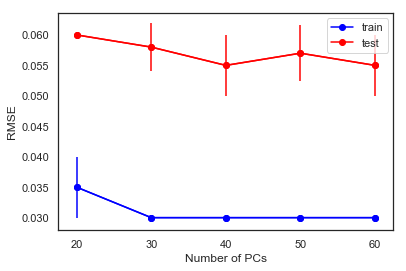

In [695]:
plt.plot(num_PCs,avg_train_score[:,1],"-o",label="train",color="blue")
plt.plot(num_PCs,avg_test_score[:,1],"-o",label="test",color="red")

plt.scatter(num_PCs,avg_train_score[:,1],color="blue")
plt.scatter(num_PCs,avg_test_score[:,1],color="red")

plt.errorbar(num_PCs,avg_train_score[:,1],yerr=std_train_score[:,1],color="blue")
plt.errorbar(num_PCs,avg_test_score[:,1],yerr=std_test_score[:,1],color="red")

plt.xlabel("Number of PCs")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(num_PCs)
plt.show()

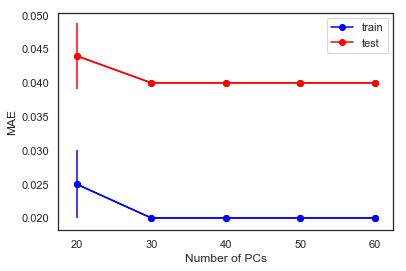

In [696]:
plt.plot(num_PCs,avg_train_score[:,2],"-o",label="train",color="blue")
plt.plot(num_PCs,avg_test_score[:,2],"-o",label="test",color="red")

plt.scatter(num_PCs,avg_train_score[:,2],color="blue")
plt.scatter(num_PCs,avg_test_score[:,2],color="red")

plt.errorbar(num_PCs,avg_train_score[:,2],yerr=std_train_score[:,2],color="blue")
plt.errorbar(num_PCs,avg_test_score[:,2],yerr=std_test_score[:,2],color="red")

plt.xlabel("Number of PCs")
plt.ylabel("MAE")
plt.legend()
plt.xticks(num_PCs)
plt.show()

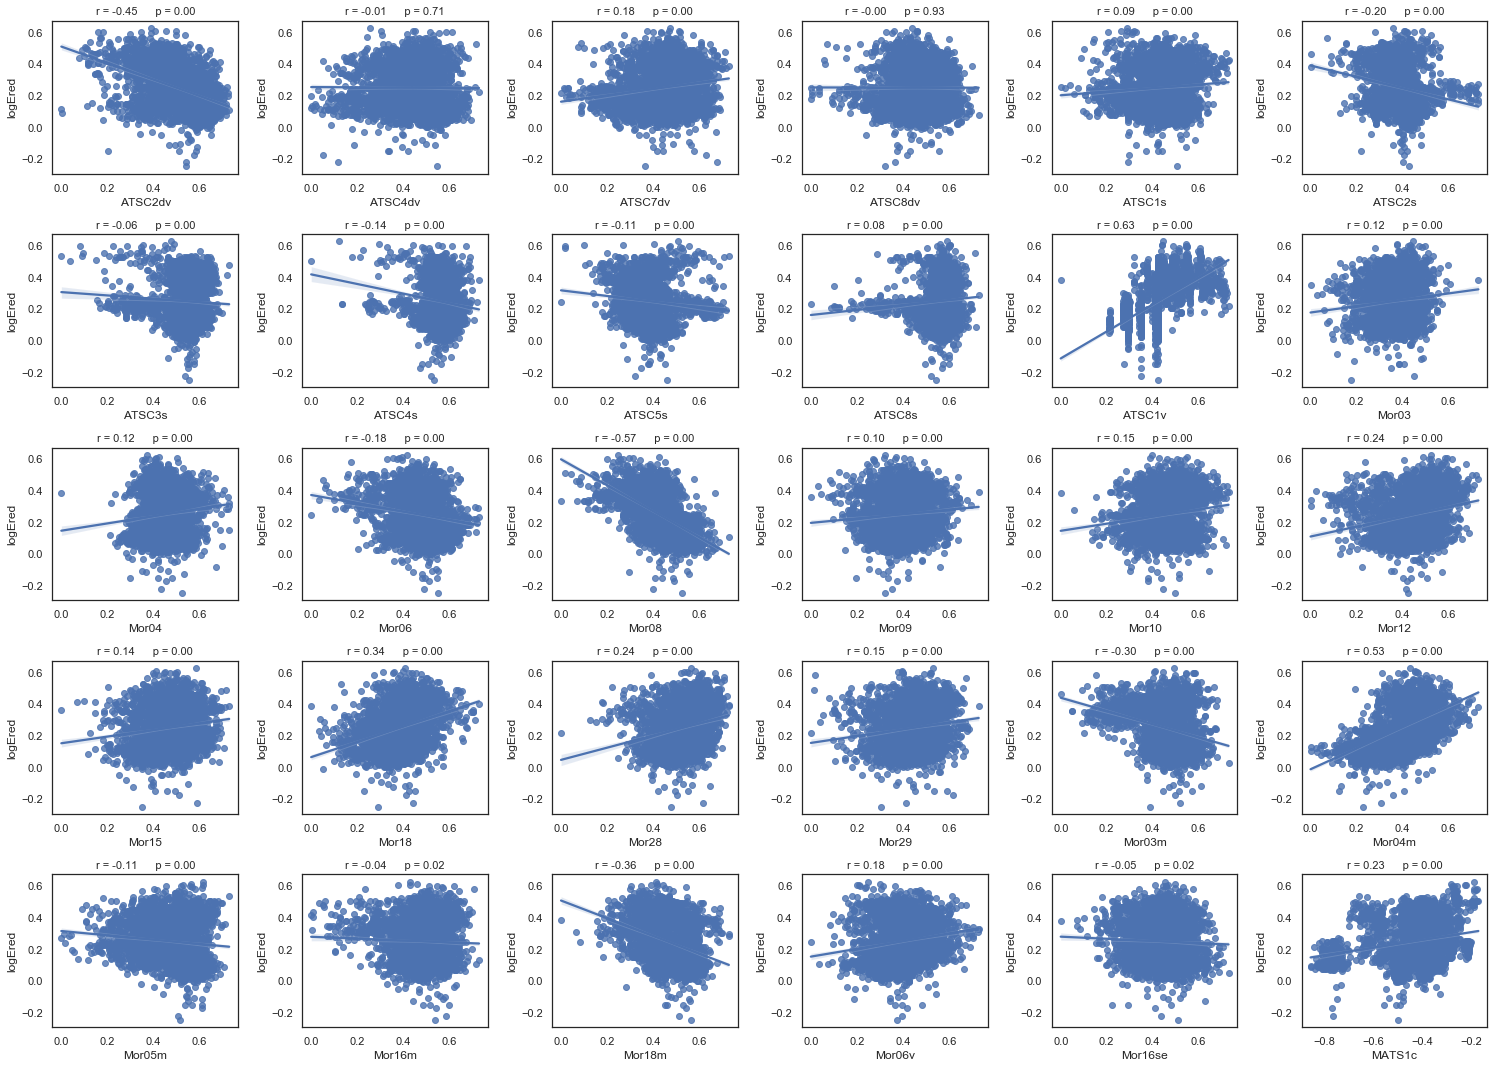

In [705]:
X=Xdata_btz_uncorr
target="logEred"

corr_ered_feat=[]

descriptors=X.columns.to_list()

nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):

            # print(i,descriptors[i])
            sns.regplot(x=X[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(X[descriptors[i]], ERed_data[target])
            # corr_ered_feat.append([descriptors[i],stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            corr_ered_feat.append([descriptors[i],stp[0]])
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

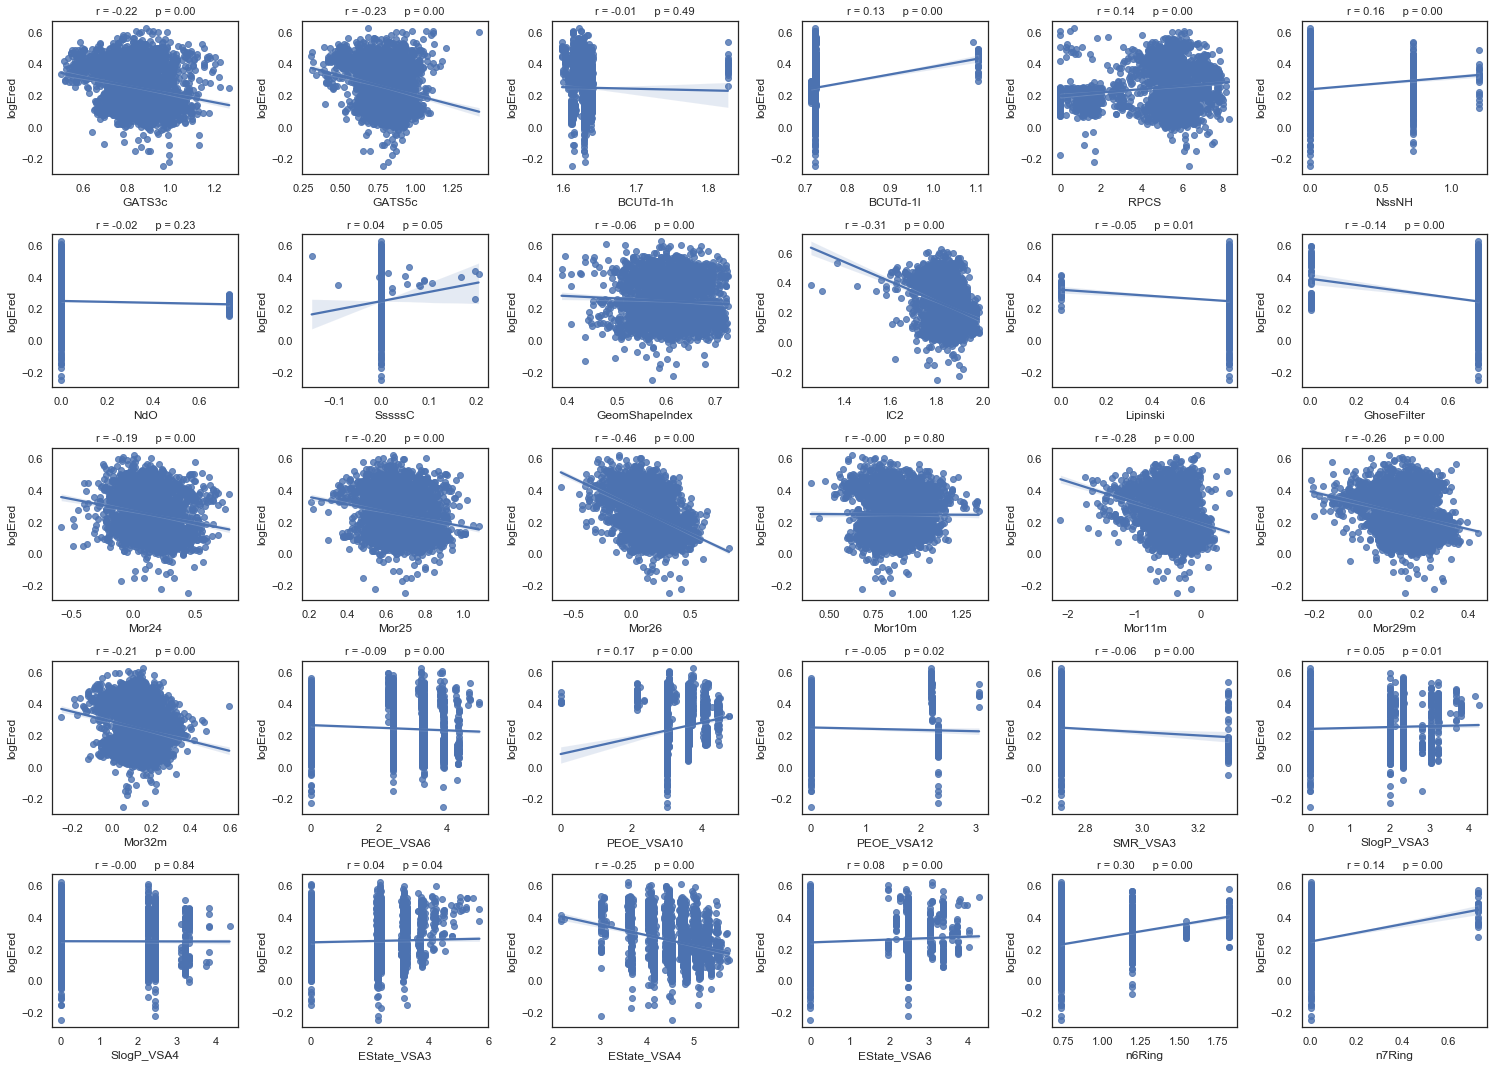

In [706]:
nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+30
        
        if i < len(descriptors):

            # print(i,descriptors[i])
            sns.regplot(x=X[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(X[descriptors[i]], ERed_data[target])
            # corr_ered_feat.append([descriptors[i],stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            corr_ered_feat.append([descriptors[i],stp[0]])
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

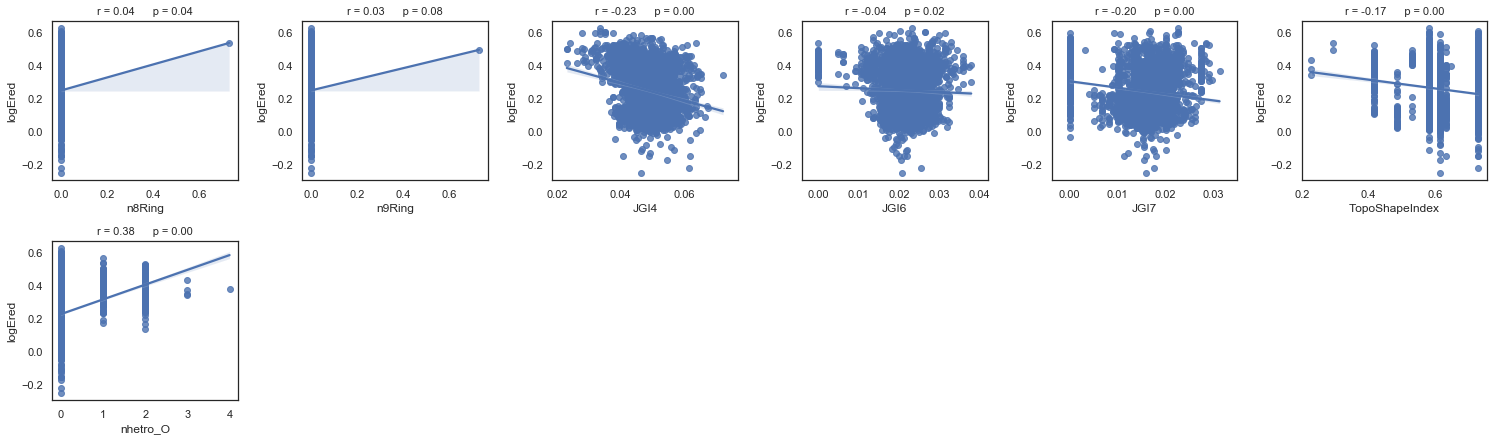

In [707]:
nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+30+30
        
        if i < len(descriptors):

            # print(i,descriptors[i])
            sns.regplot(x=X[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(X[descriptors[i]], ERed_data[target])
            # corr_ered_feat.append([descriptors[i],stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            corr_ered_feat.append([descriptors[i],stp[0]])
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

In [709]:
corr_ered_feat=pd.DataFrame(corr_ered_feat,columns=["Descriptors","Pearsons"])
remove_desc2=[i for i,desc in enumerate(corr_ered_feat["Descriptors"]) if type(desc) is int]
corr_ered_feat=corr_ered_feat.drop(remove_desc2)
corr_ered_feat_sorted=corr_ered_feat.dropna(axis=0).sort_values("Pearsons")

In [710]:
df_reducedDescp=pd.concat([corr_ered_feat_sorted[:15],corr_ered_feat_sorted[-15:]])

In [712]:
df_reducedDescp.head()

,Descriptors,Pearsons
14,Mor08,-0.569688
44,Mor26,-0.455713
0,ATSC2dv,-0.449363
26,Mor18m,-0.363721
39,IC2,-0.307099


In [713]:
df_reducedDescp.tail()

,Descriptors,Pearsons
58,n6Ring,0.303379
19,Mor18,0.342824
66,nhetro_O,0.377225
23,Mor04m,0.533230
10,ATSC1v,0.633097
